## Import Packages

In [1]:
#importing some useful packages

import os
import cv2
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
from moviepy.editor import VideoFileClip # Import everything needed to edit/save/watch video clips

get_ipython().run_line_magic('matplotlib', 'inline')


## Helper Functions

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (int(x1), int(y1), (int(x2), int(y2), color, thickness)
            
            
def Enhanced_Draw_Lines(img, lines, color=[255, 0, 0], thickness=2):

    RLane_x = [] #(slope, intercept)
    RLane_y = [] #(length,)
    LLane_x = [] # (slope, intercept)
    LLane_y = [] # length,)    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            Slope = (y2-y1) / (x2-x1)
            if (math.fabs(Slope) < 0.5):  
                continue
            if Slope <= 0: 
                LLane_x.extend([x1, x2])
                LLane_y.extend([y1, y2])
            else: 
                RLane_x.extend([x1, x2])
                RLane_y.extend([y1, y2])
                
    min_y = img.shape[0] * (3 / 5) # <-- Just below the horizon
    max_y = img.shape[0] # <-- The bottom of the image

    poly_left = np.poly1d(np.polyfit(LLane_y,LLane_x, deg=1))    
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
    
    poly_right = np.poly1d(np.polyfit(RLane_y,RLane_x,deg=1))
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))

    line_image = draw_lines(img,[[
                                    [left_x_start, max_y, left_x_end, min_y],
                                    [right_x_start, max_y, right_x_end, min_y],
                                ]],
                            thickness = 5)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def Load_Images(Path_Directory):  
    '''
    Load all images from the directory
    '''
    Images_in_Path = []
    for filename in os.listdir(Path_Directory):
        ext = os.path.splitext(filename)[1]
        if ext.lower() not in Valid_images:
            continue
        Images_in_Path.append(Image.open(os.path.join(Path_Directory,filename))) 
        
    return (Images_in_Path)


def Save_Image(Image_Number,Picture): #Sa
    '''
    Save your images to specific locations
    '''
    save_path = 'test_images_output/'
    if not os.path.exists(save_path):
                os.makedirs(save_path)
    
    filename = "image%d.png" % Image_Number             
    mpimg.imsave(os.path.join(save_path,filename),Picture)
    
    return (True)

def Process_Image(Imgs):
    
    ROT_Vertices = [(480, 300),(110,540),(880, 540)] #[Vertices,RHS(X,Y),LHS(X,Y)]
    Color_Select = np.copy(Imgs)  
        
    # printing out some stats and plotting
    print('This image is:', type(Color_Select), 'with dimesions:', Color_Select.shape) 
    
    Gray = grayscale(Color_Select)        #Apply Grayscale the image
    Blur_Gray = gaussian_blur(Gray, 3)    #Apply Gaussian smoothing
    Edges = canny(Blur_Gray, 50, 150)     #Apply Canny Algorthim
    
    # Defining a four sided polygon to mask
    Masked_Image = region_of_interest(Edges, np.array([ROT_Vertices], np.int32))
    
    #Run Hough on edge detected image
    Lines = hough_lines(Masked_Image, HTP['rho'], HTP['theta'], 
                        HTP['threshold'], HTP['min_line_len'], HTP['max_line_gap'])    

    # Draw the lines on the edge image
    Lines_Edges = weighted_img(Lines, Color_Select)

    plt.imshow(Lines_Edges)
    plt.show()

    return (Lines_Edges)

## Build a Lane Finding Pipeline



This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


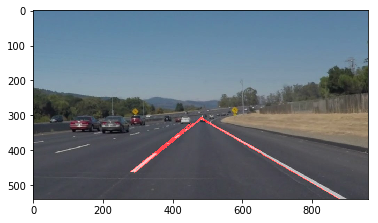

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


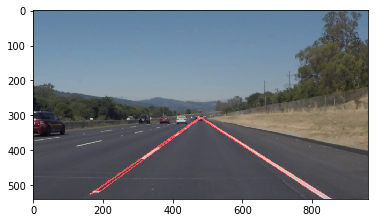

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


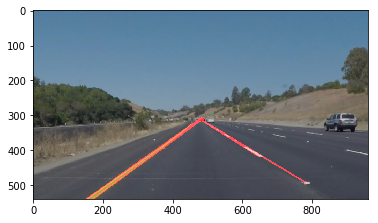

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


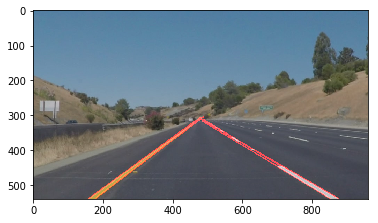

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


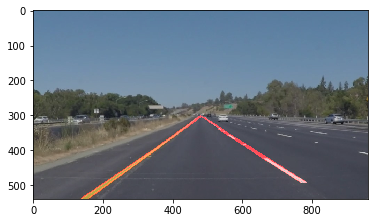

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


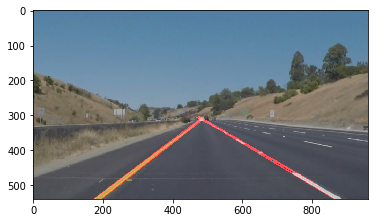

In [3]:
HTP = {#Define Hough transform parameters
       'rho':1,            #Distance resolution in pixels of the Hough grid
       'theta':np.pi/180,  #Angular resolution in radians of the Hough grid# 
       'threshold':30,     #Minimum number of votes (intersections in Hough grid cell)
       'min_line_len':50,  #Minimum number of pixels making up a line 150 - 40
       'max_line_gap':150, #Maximum gap in pixels between connectable line segments 
       }

Valid_images = [".jpg",".gif",".png",".tga"]

Imgs = Load_Images("test_images/")

for Pic in range(0,len(Imgs)): 
    Get_Test_Image = Process_Image(Imgs[Pic])
    Save_Image(Pic,Get_Test_Image)

## Test on Videos


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


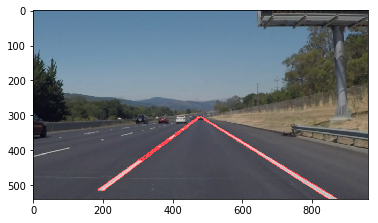

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


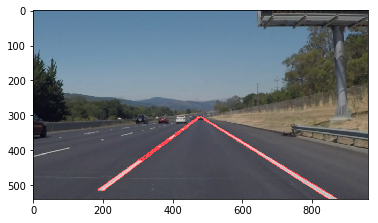

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                           | 0/76 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


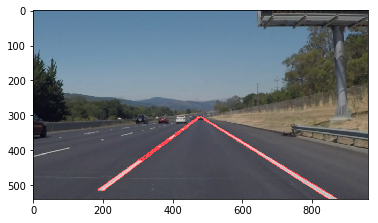

  1%|█                                                                                  | 1/76 [00:00<00:13,  5.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


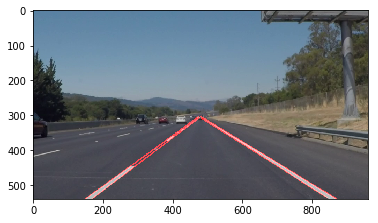

  3%|██▏                                                                                | 2/76 [00:00<00:13,  5.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


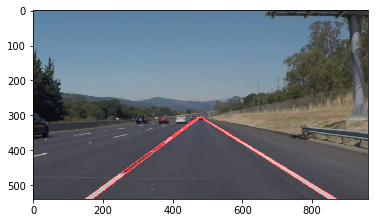

  4%|███▎                                                                               | 3/76 [00:00<00:14,  5.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


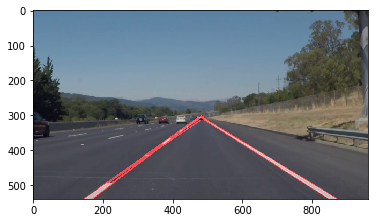

  5%|████▎                                                                              | 4/76 [00:00<00:13,  5.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


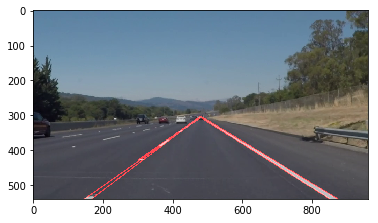

  7%|█████▍                                                                             | 5/76 [00:00<00:13,  5.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


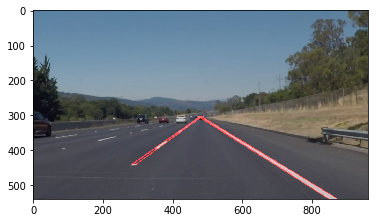

  8%|██████▌                                                                            | 6/76 [00:01<00:13,  5.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


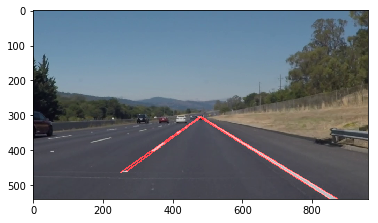

  9%|███████▋                                                                           | 7/76 [00:01<00:13,  5.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


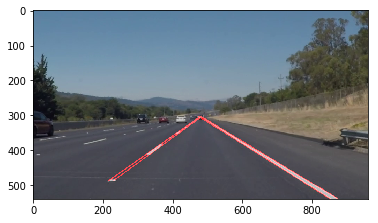

 11%|████████▋                                                                          | 8/76 [00:01<00:12,  5.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


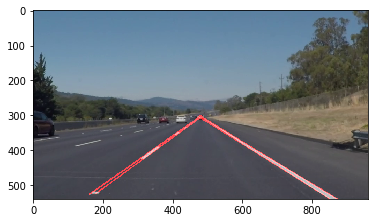

 12%|█████████▊                                                                         | 9/76 [00:01<00:12,  5.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


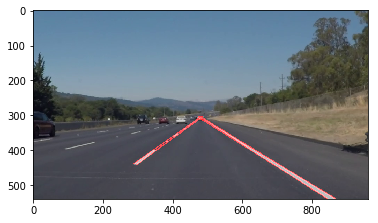

 13%|██████████▊                                                                       | 10/76 [00:01<00:12,  5.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


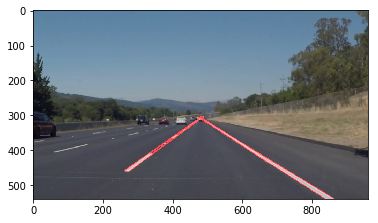

 14%|███████████▊                                                                      | 11/76 [00:02<00:12,  5.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


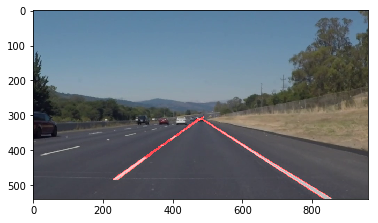

 16%|████████████▉                                                                     | 12/76 [00:02<00:11,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


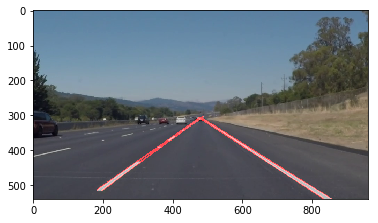

 17%|██████████████                                                                    | 13/76 [00:02<00:11,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


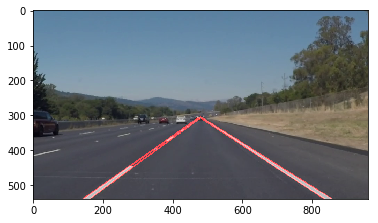

 18%|███████████████                                                                   | 14/76 [00:02<00:11,  5.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


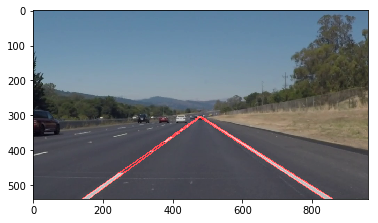

 20%|████████████████▏                                                                 | 15/76 [00:02<00:11,  5.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


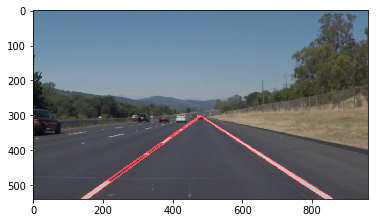

 21%|█████████████████▎                                                                | 16/76 [00:02<00:11,  5.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


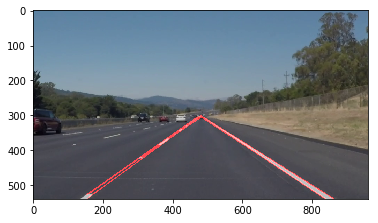

 22%|██████████████████▎                                                               | 17/76 [00:03<00:10,  5.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


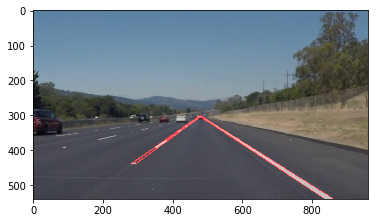

 24%|███████████████████▍                                                              | 18/76 [00:03<00:10,  5.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


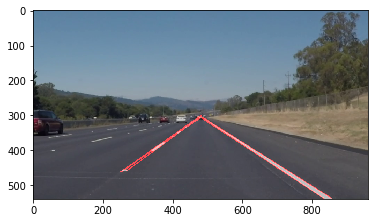

 25%|████████████████████▌                                                             | 19/76 [00:03<00:10,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


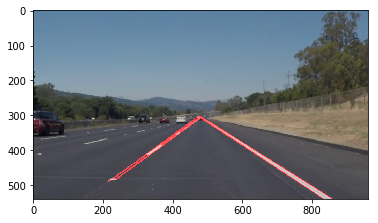

 26%|█████████████████████▌                                                            | 20/76 [00:03<00:10,  5.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


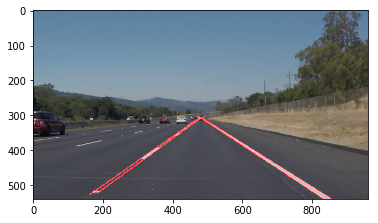

 28%|██████████████████████▋                                                           | 21/76 [00:03<00:10,  5.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


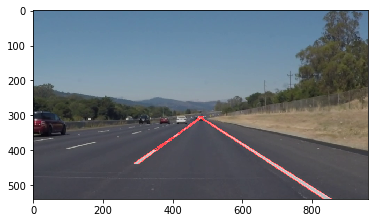

 29%|███████████████████████▋                                                          | 22/76 [00:04<00:09,  5.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


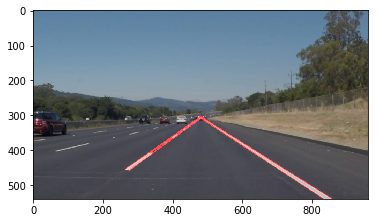

 30%|████████████████████████▊                                                         | 23/76 [00:04<00:09,  5.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


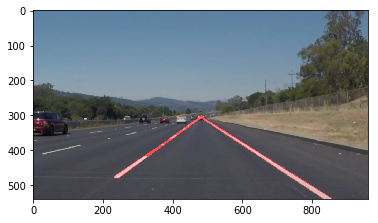

 32%|█████████████████████████▉                                                        | 24/76 [00:04<00:09,  5.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


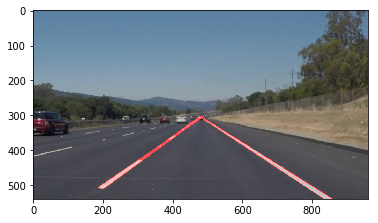

 33%|██████████████████████████▉                                                       | 25/76 [00:04<00:09,  5.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


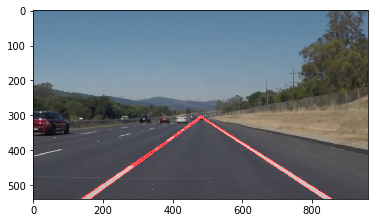

 34%|████████████████████████████                                                      | 26/76 [00:04<00:09,  5.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


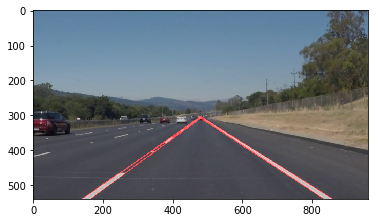

 36%|█████████████████████████████▏                                                    | 27/76 [00:04<00:09,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


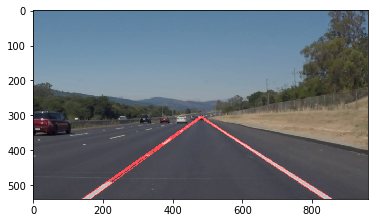

 37%|██████████████████████████████▏                                                   | 28/76 [00:05<00:08,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


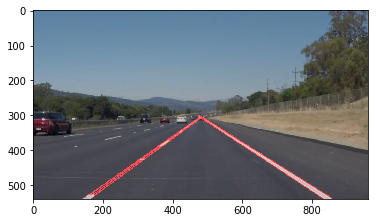

 38%|███████████████████████████████▎                                                  | 29/76 [00:05<00:08,  5.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


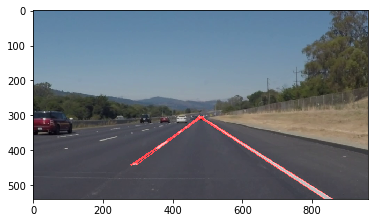

 39%|████████████████████████████████▎                                                 | 30/76 [00:05<00:08,  5.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


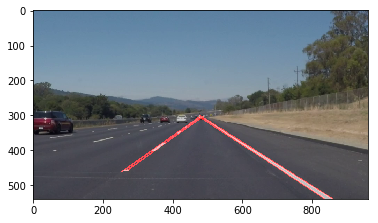

 41%|█████████████████████████████████▍                                                | 31/76 [00:05<00:08,  5.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


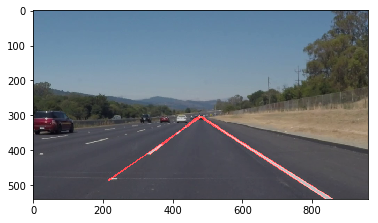

 42%|██████████████████████████████████▌                                               | 32/76 [00:05<00:08,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


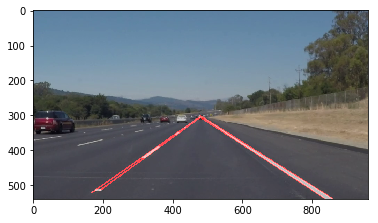

 43%|███████████████████████████████████▌                                              | 33/76 [00:06<00:07,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


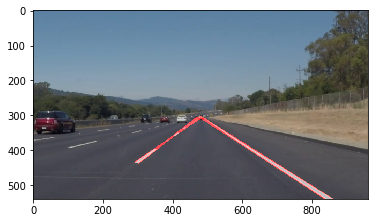

 45%|████████████████████████████████████▋                                             | 34/76 [00:06<00:07,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


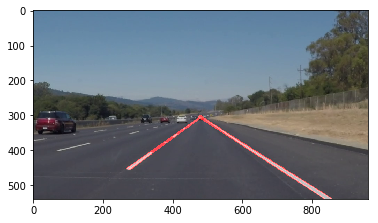

 46%|█████████████████████████████████████▊                                            | 35/76 [00:06<00:07,  5.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


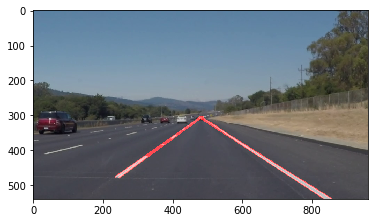

 47%|██████████████████████████████████████▊                                           | 36/76 [00:06<00:07,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


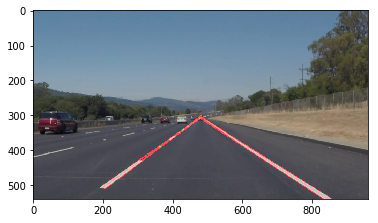

 49%|███████████████████████████████████████▉                                          | 37/76 [00:07<00:07,  5.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


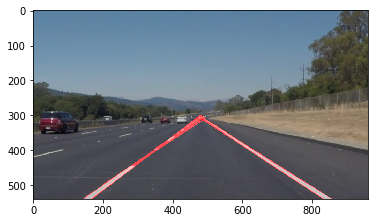

 50%|█████████████████████████████████████████                                         | 38/76 [00:07<00:07,  5.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


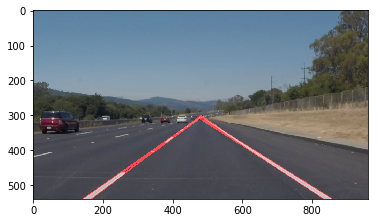

 51%|██████████████████████████████████████████                                        | 39/76 [00:07<00:07,  5.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


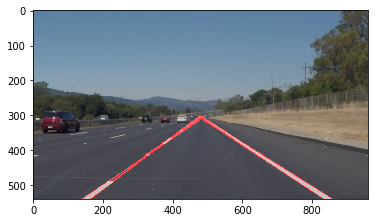

 53%|███████████████████████████████████████████▏                                      | 40/76 [00:07<00:06,  5.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


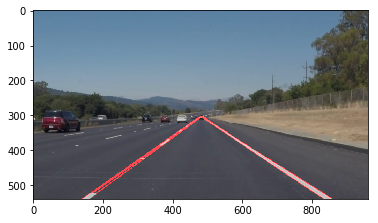

 54%|████████████████████████████████████████████▏                                     | 41/76 [00:07<00:06,  5.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


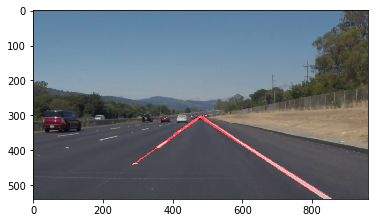

 55%|█████████████████████████████████████████████▎                                    | 42/76 [00:08<00:06,  5.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


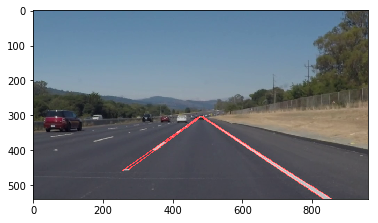

 57%|██████████████████████████████████████████████▍                                   | 43/76 [00:08<00:06,  5.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


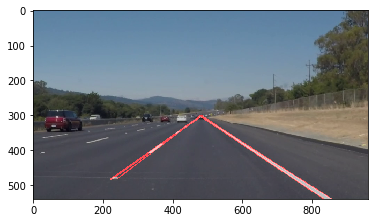

 58%|███████████████████████████████████████████████▍                                  | 44/76 [00:08<00:06,  5.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


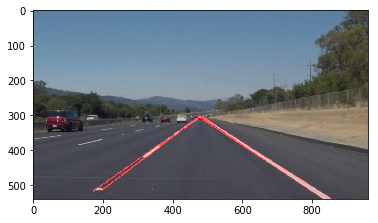

 59%|████████████████████████████████████████████████▌                                 | 45/76 [00:08<00:05,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


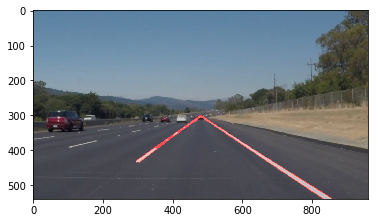

 61%|█████████████████████████████████████████████████▋                                | 46/76 [00:08<00:05,  5.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


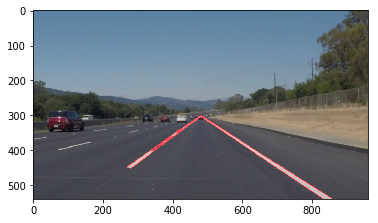

 62%|██████████████████████████████████████████████████▋                               | 47/76 [00:08<00:05,  5.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


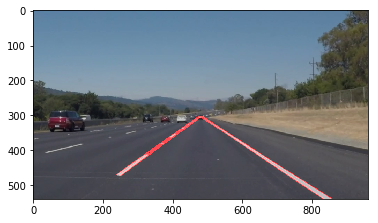

 63%|███████████████████████████████████████████████████▊                              | 48/76 [00:09<00:05,  5.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


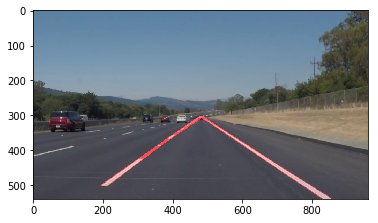

 64%|████████████████████████████████████████████████████▊                             | 49/76 [00:09<00:05,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


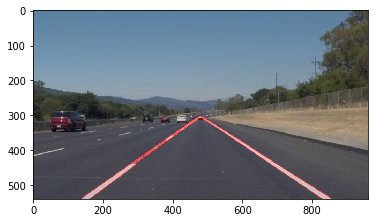

 66%|█████████████████████████████████████████████████████▉                            | 50/76 [00:09<00:04,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


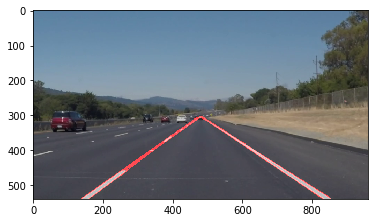

 67%|███████████████████████████████████████████████████████                           | 51/76 [00:09<00:04,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


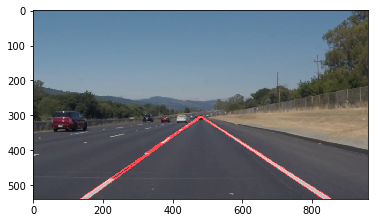

 68%|████████████████████████████████████████████████████████                          | 52/76 [00:09<00:04,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


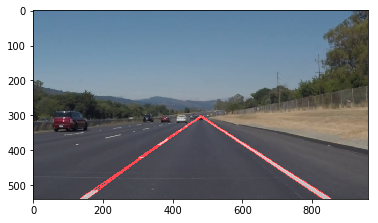

 70%|█████████████████████████████████████████████████████████▏                        | 53/76 [00:10<00:04,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


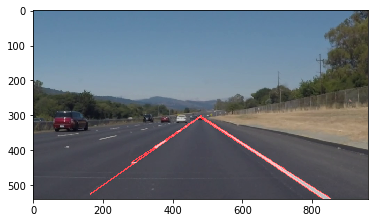

 71%|██████████████████████████████████████████████████████████▎                       | 54/76 [00:10<00:04,  5.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


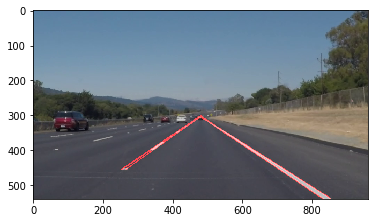

 72%|███████████████████████████████████████████████████████████▎                      | 55/76 [00:10<00:04,  5.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


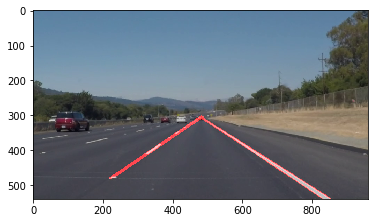

 74%|████████████████████████████████████████████████████████████▍                     | 56/76 [00:10<00:03,  5.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


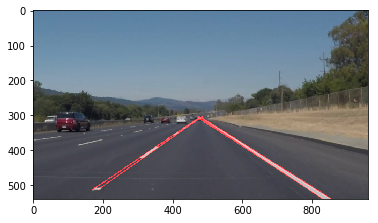

 75%|█████████████████████████████████████████████████████████████▌                    | 57/76 [00:10<00:03,  5.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


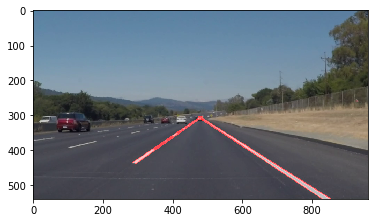

 76%|██████████████████████████████████████████████████████████████▌                   | 58/76 [00:11<00:03,  5.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


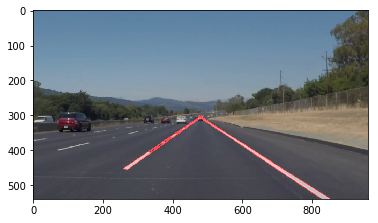

 78%|███████████████████████████████████████████████████████████████▋                  | 59/76 [00:11<00:03,  5.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


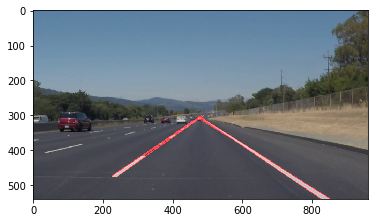

 79%|████████████████████████████████████████████████████████████████▋                 | 60/76 [00:11<00:03,  5.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


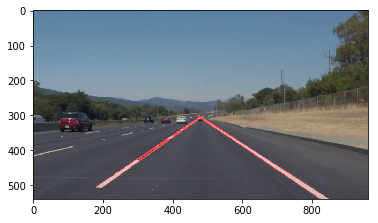

 80%|█████████████████████████████████████████████████████████████████▊                | 61/76 [00:11<00:02,  5.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


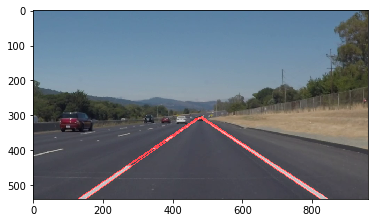

 82%|██████████████████████████████████████████████████████████████████▉               | 62/76 [00:11<00:02,  5.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


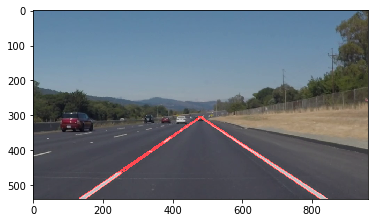

 83%|███████████████████████████████████████████████████████████████████▉              | 63/76 [00:12<00:02,  5.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


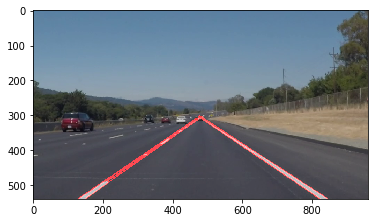

 84%|█████████████████████████████████████████████████████████████████████             | 64/76 [00:12<00:02,  5.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


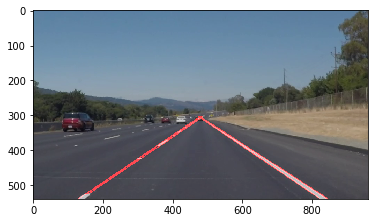

 86%|██████████████████████████████████████████████████████████████████████▏           | 65/76 [00:12<00:02,  5.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


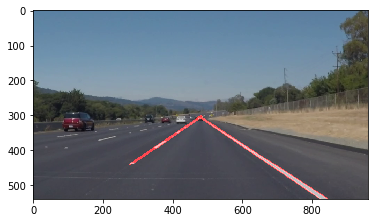

 87%|███████████████████████████████████████████████████████████████████████▏          | 66/76 [00:12<00:01,  5.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


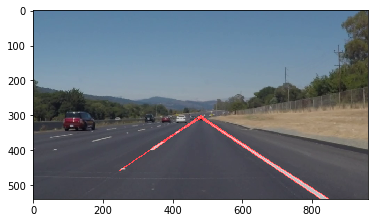

 88%|████████████████████████████████████████████████████████████████████████▎         | 67/76 [00:12<00:01,  5.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


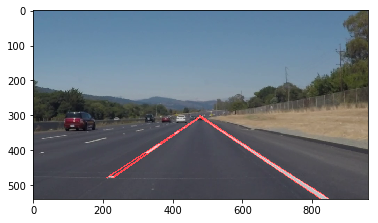

 89%|█████████████████████████████████████████████████████████████████████████▎        | 68/76 [00:13<00:01,  5.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


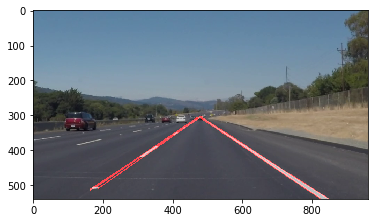

 91%|██████████████████████████████████████████████████████████████████████████▍       | 69/76 [00:13<00:01,  5.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


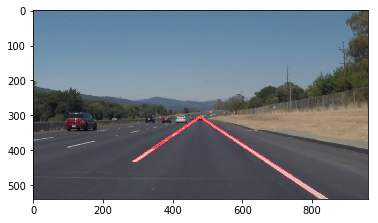

 92%|███████████████████████████████████████████████████████████████████████████▌      | 70/76 [00:13<00:01,  5.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


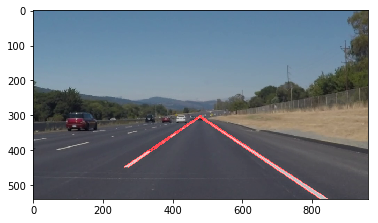

 93%|████████████████████████████████████████████████████████████████████████████▌     | 71/76 [00:13<00:00,  5.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


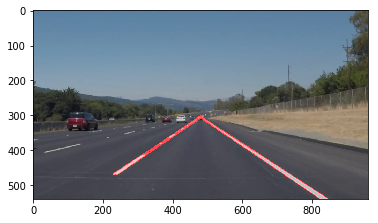

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 72/76 [00:13<00:00,  5.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


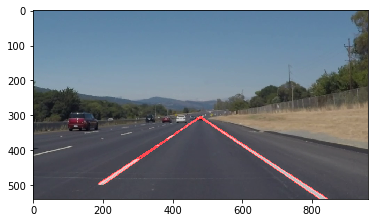

 96%|██████████████████████████████████████████████████████████████████████████████▊   | 73/76 [00:14<00:00,  5.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


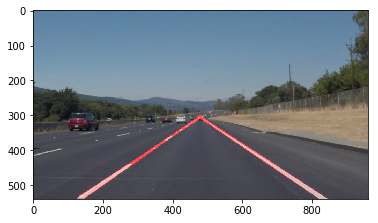

 97%|███████████████████████████████████████████████████████████████████████████████▊  | 74/76 [00:14<00:00,  5.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


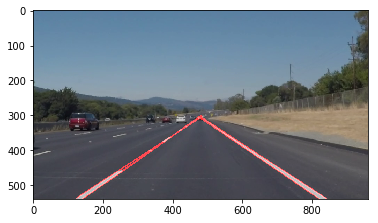

 99%|████████████████████████████████████████████████████████████████████████████████▉ | 75/76 [00:14<00:00,  5.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



In [4]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
Video_1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
Video_1.reader.close()
Video_1.audio.reader.close_proc()
white_clip = Video_1.fl_image(Process_Image).subclip(0,3)#NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function


In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
Video_2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
Video_2.reader.close()
Video_2.audio.reader.close_proc()
yellow_clip = Video_2.fl_image(Process_Image)
yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
